In [1]:
'''
code for generating the scene pcd from two different viewpoints and then registering them in the global frame 
'''

import random
from glob import glob 
import os
import os.path as osp
import numpy as np
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import open3d as o3d
from copy import deepcopy

def get_paths(dirpath, camera_path):
    color_images = sorted(glob(dirpath + '/*.png'))
    depth_images = sorted(glob(dirpath + '/*.exr'))
    camera_transforms = sorted(glob(camera_path + '/*.txt'))

    random_idx = random.randint(0, len(color_images)-1)

    rgb_image = color_images[random_idx]
    depth_image = depth_images[random_idx]
    camera_transform = camera_transforms[random_idx]
    
    print(f'Random idx : {random_idx}')
    
#     random_idx2 = random.randint(0, len(color_images)-1)
    
#     rgb_image2 = color_images[random_idx2]
#     depth_image2 = depth_images[random_idx2]
#     camera_transform2 = camera_transforms[random_idx2]

#     return rgb_image1, depth_image1, camera_transform1, rgb_image2, depth_image2, camera_transform2
    return rgb_image, depth_image, camera_transform
    
# read the camera intrinsics 
def read_camera_intrinsics(camk_path):
    with open(camk_path, 'r') as f: 
        intrinsics = [[int(float(num)) for num in line.split(' ')] for line in f]
    
    fx, fy, cx, cy = intrinsics[0][0], intrinsics[1][1], intrinsics[0][2], intrinsics[1][2]
    
    return fx, fy, cx, cy, intrinsics

# read the image and depth information along with the camera matrix 
import matplotlib.pyplot as plt 
import cv2

def get_values(rgb_image, depth_image, camera_extrinsics_path):
    rgb = cv2.cvtColor(cv2.imread(rgb_image), cv2.COLOR_BGR2RGB)
    depth = cv2.imread(depth_image, cv2.IMREAD_ANYDEPTH)
    
    with open(camera_extrinsics_path, 'r') as f:
        camera_matrix = np.asarray([[float(num) for num in line.split(' ')] for line in f])

    height, width, _ = rgb.shape
    
    return rgb, depth, camera_matrix

def generate_pcd_o3d(rgb, depth, fx, fy, cx, cy, extrinsic=None):
    height, width, _ = rgb.shape
    
    o3d_rgb = o3d.geometry.Image(rgb)
    o3d_depth = o3d.geometry.Image(depth)
    
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(o3d_rgb, o3d_depth, depth_scale=1, convert_rgb_to_intensity=False)
    
    pinhole_camera = o3d.camera.PinholeCameraIntrinsic(
        width,
        height, 
        fx, 
        fy, 
        cx, 
        cy
    )
    
    if extrinsic is not None:
        pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, pinhole_camera) #, extrinsic)
        pcd = pcd.transform(extrinsic)
    else:
        pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, pinhole_camera)

    return pcd

def generate_pcd(rgb_img, depth_map, cam_K, cam_RT):
    u, v = np.meshgrid(range(depth_map.shape[1]), range(depth_map.shape[0]))
    u = u.reshape([1, -1])[0]
    v = v.reshape([1, -1])[0]

    z = depth_map[v, u]

    # remove infinitive pixels
    non_inf_indices = np.argwhere(z < np.inf).T[0]

    color_indices = rgb_img[v, u][non_inf_indices]/255.0
    
    z = z[non_inf_indices]
    u = u[non_inf_indices]
    v = v[non_inf_indices]

    # calculate coordinates
    x = (u - cam_K[0][2]) * z / cam_K[0][0]
    y = (v - cam_K[1][2]) * z / cam_K[1][1]

    point_cam = np.vstack([x, y, z]).T

    point_canonical = (point_cam - cam_RT[:, -1]).dot(cam_RT[:,:-1])
    cam_pos = - cam_RT[:, -1].dot(cam_RT[:,:-1])
    focal_point = ([0, 0, 1] - cam_RT[:, -1]).dot(cam_RT[:,:-1])
    up = np.array([0,-1,0]).dot(cam_RT[:,:-1])

    # print(f'points in the camera frame : {point_cam.shape}, points in the canonical frame : {point_canonical.shape}')

    # these should be the points in the camera frame 
    cam_pcd = o3d.geometry.PointCloud()
    cam_pcd.points = o3d.utility.Vector3dVector(point_cam)
    cam_pcd.colors = o3d.utility.Vector3dVector(color_indices)

    # these should be the points in the canonical frame
    can_pcd = o3d.geometry.PointCloud()
    can_pcd.points = o3d.utility.Vector3dVector(point_canonical)
    can_pcd.colors = o3d.utility.Vector3dVector(color_indices)
    
    return cam_pcd, can_pcd # returns the pcd in the camera frame and the canonical frame 

def visualize_image(image):
    plt.figure()
    plt.imshow(image)

def visualize_pcd(pcd):
    o3d.visualization.draw_geometries(pcd)

# read the camera parameters (camera intrinsics) 
camk_path = '/home/aditya/Research/phd/code/depth_renderer/datasets/camera_settings/cam_K/cam_K.txt'

fx, fy, cx, cy, intrinsics = read_camera_intrinsics(camk_path)

print(f'Intrinsics are : {fx, fy, cx, cy}')

# print(f'rgb image : {rgb_image}, depth image : {depth_image}, camera transform : {camera_transform}')
shapenet_category_pair = {
    'table' : '04379243',
    'jar' : '03593526',
    'skateboard' : '04225987',
    'car' : '02958343',
    'bottle' : '02876657',
    'tower' : '04460130',
    'chair' : '03001627',
    'bookshelf' : '02871439',
    'camera' : '02942699',
    'airplane' : '02691156',
    'laptop' : '03642806',
    'basket' : '02801938',
    'sofa' : '04256520',
    'knife' : '03624134',
    'can' : '02946921',
    'rifle' : '04090263',
    'train' : '04468005',
    'pillow' : '03938244',
    'lamp' : '03636649',
    'trash bin' : '02747177',
    'mailbox' : '03710193',
    'watercraft' : '04530566',
    'motorbike' : '03790512',
    'dishwasher' : '03207941',
    'bench' : '02828884',
    'pistol' : '03948459',
    'rocket' : '04099429',
    'loudspeaker' : '03691459',
    'file cabinet' : '03337140',
    'bag' : '02773838',
    'cabinet' : '02933112',
    'bed' : '02818832',
    'birdhouse' : '02843684',
    'display' : '03211117',
    'piano' : '03928116',
    'earphone' : '03261776',
    'telephone' : '04401088',
    'stove' : '04330267',
    'microphone' : '03759954',
    'bus' : '02924116',
    'mug' : '03797390',
    'remote' : '04074963',
    'bathtub' : '02808440',
    'bowl' : '02880940',
    'keyboard' : '03085013',
    'guitar' : '03467517',
    'washer' : '04554684',
    'bicycle' : '02834778',
    'faucet' : '03325088',
    'printer' : '04004475',
    'cap' : '02954340',
    'clock' : '03046257',
    'helmet' : '03513137',
    'flowerpot' : '03991062',
    'microwaves' : '03761084'
}
cat_id = shapenet_category_pair['car']
# cat_id = shapenet_category_pair['cap']

un_obj_dirpath = '/home/aditya/Research/phd/code/datasets/shapenetcore/{}'.format(cat_id)
obj_dirpath = '/home/aditya/Research/phd/code/depth_renderer/datasets/ShapeNetCore.v2_normalized/{}'.format(cat_id)
renders_dirpath = '/home/aditya/Research/phd/code/depth_renderer/datasets/ShapeNetRenderings/{}'.format(cat_id)

dirs = glob(renders_dirpath + '/*')
dirname = osp.basename(dirs[random.randint(0, len(dirs)-1)])

dirpath = osp.join(renders_dirpath, dirname)
obj_path = osp.join(obj_dirpath, dirname, 'models/model_normalized.obj')
un_obj_path = osp.join(un_obj_dirpath, dirname, 'models/model_normalized.obj')
print(f'File existence : {osp.exists(un_obj_path)}')

print(f'Dirpath is : {dirpath}, obj_path is : {obj_path}')

camera_path = '/home/aditya/Research/phd/code/depth_renderer/datasets/camera_settings/cam_RT/'

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Intrinsics are : (560, 560, 256, 256)
File existence : True
Dirpath is : /home/aditya/Research/phd/code/depth_renderer/datasets/ShapeNetRenderings/02958343/e67509fb6192be6a7e7e5ea49ad8e45, obj_path is : /home/aditya/Research/phd/code/depth_renderer/datasets/ShapeNetCore.v2_normalized/02958343/e67509fb6192be6a7e7e5ea49ad8e45/models/model_normalized.obj


In [2]:
rgb_path1, depth_path1, camera_transform1 = get_paths(dirpath, camera_path)
rgb_path2, depth_path2, camera_transform2 = get_paths(dirpath, camera_path)

rgb1, depth1, camera_matrix1 = get_values(rgb_path1, depth_path1, camera_transform1)
rgb2, depth2, camera_matrix2 = get_values(rgb_path2, depth_path2, camera_transform2)

o3d_pcd1 = generate_pcd_o3d(rgb1, depth1, fx, fy, cx, cy)
o3d_pcd2 = generate_pcd_o3d(rgb2, depth2, fx, fy, cx, cy)

pcd1, pcd1_canonical = generate_pcd(rgb1, depth1, intrinsics, camera_matrix1)
pcd2, pcd2_canonical = generate_pcd(rgb2, depth2, intrinsics, camera_matrix2)

camera_matrix1 = np.vstack([np.asarray(camera_matrix1, dtype=np.float64), [0, 0, 0, 1]])
camera_matrix2 = np.vstack([np.asarray(camera_matrix2, dtype=np.float64), [0, 0, 0, 1]])

# load the pointcloud of the object 
mesh_pcd = ((o3d.io.read_triangle_mesh(obj_path)).sample_points_uniformly(10000)).farthest_point_down_sample(2048)

Random idx : 17
Random idx : 14
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitiv

In [322]:
# plot all camera matrices along with the object mesh
# load the obj mesh
mesh = o3d.io.read_triangle_mesh(obj_path).sample_points_uniformly(10000).farthest_point_down_sample(2048)
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
o3d.visualization.draw_geometries([mesh, coordinate_frame])

# read all the camera matrices 
camera_matrices = []
camera_transforms = sorted(glob(camera_path + '/*.txt'))

for camera_transform in camera_transforms:
    with open(camera_transform) as f:
        print(f'Reading file : {camera_transform}')
        camera_matrix = [[float(num) for num in line.split(' ')] for line in f]
        camera_matrix = np.vstack([np.asarray(camera_matrix, dtype=np.float64), [0, 0, 0, 1]])
        camera_matrices.append(camera_matrix)

print(camera_matrices)
print(camera_matrices[0].shape)

# create coordinate frame for each camera matrix
coordinate_frames = []
for camera_matrix in camera_matrices:
    coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
    coordinate_frame.transform(camera_matrix)
    coordinate_frames.append(coordinate_frame)

coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])

# visualize all the camera matrices
# code to append mesh and coordinate_frame to the coordinate_frames list
coordinate_frames.append(mesh)
coordinate_frames.append(coordinate_frame)

# visualize all the camera matrices
o3d.visualization.draw_geometries(coordinate_frames)

[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D IN

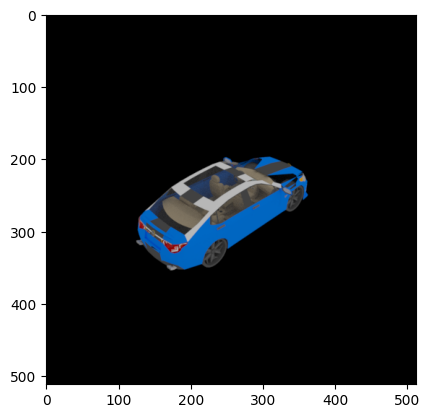

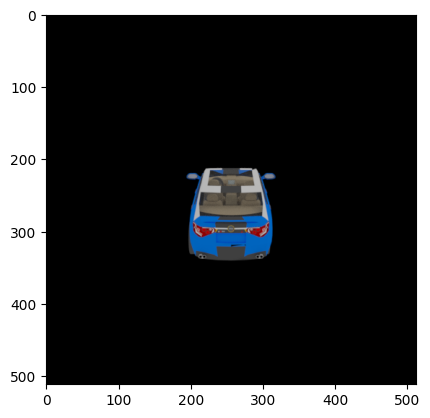

In [226]:
from copy import deepcopy

visualize_image(rgb1)
visualize_image(rgb2)

# transform the coordinate frame by the position of the camera 
cam_pose1 = - camera_matrix1[:, -1].dot(camera_matrix1[:,:-1])

coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)

# transform the coordinate frame by the camera pose -- to find the camera pose 
# cam_frame1 = deepcopy(coordinate_frame).transform(cam_pose1)

# visualize the pcds generated by the open3d method 
# visualize_pcd([o3d_pcd1])
# visualize_pcd([o3d_pcd2])

# visualize_pcd([pcd1])

# print(np.asarray(o3d_pcd1.points))
# print(np.array(pcd1.points))

# visualize_pcd([coordinate_frame, pcd1, pcd2, mesh_pcd])

# visualize_pcd(pcd1)
# visualize_pcd(pcd2)

# transform pcd1 and pcd2 
pcd1_transformed = deepcopy(pcd1).transform(np.linalg.inv(camera_matrix1))#.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

visualize_pcd([pcd1, pcd1_transformed, pcd2, mesh])

In [150]:
# we essentially have the same pointcloud generated using the open3d method and using our defined method 
extrinsic_matrix = np.array([[1., 0., 0., 0.],
                             [0., 1., 0., 0.],
                             [0., 0., 1., 0.],
                             [0., 0., 0., 1.]], dtype=np.float64)

print(f'The camera transformation matrix is : {camera_matrix1}')
o3d_pcd1_camera = generate_pcd_o3d(rgb1, depth1, fx, fy, cx, cy, extrinsic=camera_matrix1)

o3d_pcd1_world = generate_pcd_o3d(rgb1, depth1, fx, fy, cx, cy)

# o3d_pcd1_world_transformed = o3d_pcd1_world.transform(np.linalg.inv(camera_matrix1)) #-- this is an inplace operation
o3d_pcd1_world_transformed = deepcopy(o3d_pcd1_world)
o3d_pcd1_world_transformed.transform(np.linalg.inv(camera_matrix1))

# register the pointcloud in the world frame and camera frame 
visualize_pcd([o3d_pcd1_camera, o3d_pcd1_world])
# visualize_pcd([o3d_pcd1_world_transformed, o3d_pcd1_world])
visualize_pcd([o3d_pcd1_world_transformed, o3d_pcd1_camera])

The camera transformation matrix is : [[ 3.63437742e-08 -2.07237179e-08 -9.99999940e-01  1.32839499e-08]
 [ 9.34172153e-01 -3.56822520e-01  4.39901378e-08  0.00000000e+00]
 [-3.56822520e-01 -9.34172213e-01  2.07237179e-08  2.07846117e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [112]:
# transform the pointclouds from multiple views to the world framem and register them together 
o3d_pcd1 = generate_pcd_o3d(rgb1, depth1, fx, fy, cx, cy)
o3d_pcd2 = generate_pcd_o3d(rgb2, depth2, fx, fy, cx, cy)

# transform the pointclouds from their camera coordinates to the world coordinates 
o3d_pcd1_world = deepcopy(o3d_pcd1)
o3d_pcd1_world.transform(np.linalg.inv(camera_matrix1))

o3d_pcd2_world = deepcopy(o3d_pcd2)
o3d_pcd2_world.transform(np.linalg.inv(camera_matrix2))

coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)

o3d.visualization.draw_geometries([o3d_pcd1, o3d_pcd2, coordinate_frame])
o3d.visualization.draw_geometries([o3d_pcd1_world, o3d_pcd2_world, coordinate_frame]) # hopefully these are in the world frame
o3d.visualization.draw_geometries([pcd1_canonical, pcd2_canonical, coordinate_frame])

In [151]:
# load the full pointcloud and the pointcloud in the camera frame 
object_pcd = ((o3d.io.read_triangle_mesh(obj_path)).sample_points_uniformly(10000)).farthest_point_down_sample(2048)
# load one of the view-dependent partial pointclouds 
pcd1_partial = generate_pcd_o3d(rgb1, depth1, fx, fy, cx, cy)
visualize_pcd([pcd, pcd1_partial])

# transform the pointcloud in the world frame to the camera frame
object_pcd_transformed = deepcopy(object_pcd)
object_pcd_transformed.transform(camera_matrix1)

visualize_pcd([pcd1_partial, object_pcd_transformed])

In [174]:
# load the pointcloud fromo the mesh and register a view-dependent partial pointcloud and the full pointcloud together 
# dirpath = '../datasets/ShapeNetCore.v2_normalized/02691156'
# from glob import glob 
# model_files = glob(dirpath + '/*/models/model_normalized.obj')

# filename = model_files[random.randint(0, len(model_files)-1)]
print(obj_path)
mesh = o3d.io.read_triangle_mesh(obj_path)
num_points = 10000
pcd = mesh.sample_points_uniformly(number_of_points=num_points)

mesh_un = o3d.io.read_triangle_mesh(un_obj_path)
pcd_un = mesh_un.sample_points_uniformly(number_of_points=num_points)

o3d.visualization.draw_geometries([pcd, pcd2_canonical])
# o3d.visualization.draw_geometries([pcd_un, pcd2_canonical])
# o3d.visualization.draw_geometries([pcd, pcd_un])

/home/aditya/Research/phd/code/depth_renderer/datasets/ShapeNetCore.v2_normalized/02958343/bbf01f037b55306f8c2fb4d10f176f65/models/model_normalized.obj


In [186]:
# load the partial pointcloud without the camera extrinsics 
# load the partial pointcloud from another viewpoint without the camera extrinsics 
# load the obj model pointcloud without the camera extrinsics 

c2w_1 = np.linalg.inv(camera_matrix1)
o3d_pcd1 = generate_pcd_o3d(rgb1, depth1, fx, fy, cx, cy, extrinsic=c2w_1)
c2w_2 = np.linalg.inv(camera_matrix2)
o3d_pcd2 = generate_pcd_o3d(rgb2, depth2, fx, fy, cx, cy, extrinsic=c2w_2)

cframe_transformed1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.15)
cframe_transformed1.transform(np.linalg.inv(camera_matrix1))

cframe_transformed2 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.15)
cframe_transformed2.transform(np.linalg.inv(camera_matrix2))

coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.3)

world_pcd = o3d.io.read_triangle_mesh(obj_path).sample_points_uniformly(10000).farthest_point_down_sample(2048)

# for the pcds -- rotate and translate them using the rotation and translation values 
R1 = camera_matrix1[:-1, :-1]
T1 = camera_matrix1[:-1, -1]

R2 = camera_matrix2[:-1, :-1]
T2 = camera_matrix2[:-1, -1]

# visualize_pcd([o3d_pcd1, coordinate_frame, cframe_transformed1, world_pcd])
visualize_pcd([o3d_pcd1, o3d_pcd2, cframe_transformed1, cframe_transformed2, world_pcd, coordinate_frame])

[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D WARNING] Read geometry::Image failed: file extension tga unknown


In [179]:
visualize_pcd([o3d_pcd1, o3d_pcd2, world_pcd, coordinate_frame])#1, coordinate_frame2]) # how do i get them to the same frame 

pcd1_points = (np.array(o3d_pcd1.points)-T1)@R1
pcd2_points = (np.array(o3d_pcd2.points)-T2)@R2

# try to visualize the points now 
pcd1_transformed = o3d.geometry.PointCloud()
pcd2_transformed = o3d.geometry.PointCloud()

pcd1_transformed.points = o3d.utility.Vector3dVector(pcd1_points)
pcd2_transformed.points = o3d.utility.Vector3dVector(pcd2_points)

o3d.visualization.draw_geometries([pcd1_transformed, pcd2_transformed, world_pcd])

In [4]:
# create the pointcloud from Blender's camera matrix and rgb and depth images 
import bpy
def create_pointcloud(rgb_file, depth_file, cam_file, z_offset=0.0):
    """ create point cloud from rgb and depth image

    Args:
        rgb_file: path to rgb image
        depth_file: path to depth image
        cam_file: path to camera info
        output_file: path to store point cloud
        z_offset: offset of z axis
    """
    rgb = bpy.data.images.load(rgb_file)
    depth = bpy.data.images.load(depth_file)
    K = np.loadtxt(cam_file)

    # create point cloud
    points = []
    g_resolution_x, g_resolution_y = 512, 512
    for v in range(g_resolution_y):
        for u in range(g_resolution_x):
            color = rgb.pixels[(v * g_resolution_x + u) * 4: (v * g_resolution_x + u + 1) * 4]
            Z = depth.pixels[(v * g_resolution_x + u) * 4]
            if Z == 0:
                continue
            X = (u - K[0][2]) * Z / K[0][0]
            Y = (v - K[1][2]) * Z / K[1][1]
            points.append([X, Y, Z, color[0], color[1], color[2]])

    # create open3d pointcloud 
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.array(points)[:, :3])
    pcd.colors = o3d.utility.Vector3dVector(np.array(points)[:, 3:6])
    pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, z_offset], [0, 0, 0, 1]])
    o3d.visualization.draw_geometries([pcd])
    
rgb_file, depth_file, cam_file = get_paths(dirpath, camera_path)
create_pointcloud(rgb_file, depth_file, cam_file)

Random idx : 9


In [5]:
def get_point_cloud(depth_maps, cam_Ks, cam_RTs, rgb_imgs=None):
    '''
    get point cloud from depth maps
    :param depth_maps: depth map list
    :param cam_Ks: corresponding camera intrinsics
    :param cam_RTs: corresponding camera rotations and translations
    :param rgb_imgs: corresponding rgb images
    :return: aligned point clouds in the canonical system with color intensities.
    '''
    point_list_canonical = []
    camera_positions = []
    color_intensities = []

    if not isinstance(rgb_imgs, np.ndarray):
        rgb_imgs = 32*np.ones([depth_maps.shape[0], depth_maps.shape[1], depth_maps.shape[2], 3], dtype=np.uint8)

    for depth_map, rgb_img, cam_K, cam_RT in zip(depth_maps, rgb_imgs, cam_Ks, cam_RTs):
        u, v = np.meshgrid(range(depth_map.shape[1]), range(depth_map.shape[0]))
        u = u.reshape([1, -1])[0]
        v = v.reshape([1, -1])[0]

        z = depth_map[v, u]

        # remove infinitive pixels
        non_inf_indices = np.argwhere(z < np.inf).T[0]

        color_indices = rgb_img[v, u][non_inf_indices]
        z = z[non_inf_indices]
        u = u[non_inf_indices]
        v = v[non_inf_indices]

        # calculate coordinates
        x = (u - cam_K[0][2]) * z / cam_K[0][0]
        y = (v - cam_K[1][2]) * z / cam_K[1][1]

        point_cam = np.vstack([x, y, z]).T

        point_canonical = (point_cam - cam_RT[:, -1]).dot(cam_RT[:,:-1])
        cam_pos = - cam_RT[:, -1].dot(cam_RT[:,:-1])
        focal_point = ([0, 0, 1] - cam_RT[:, -1]).dot(cam_RT[:,:-1])
        up = np.array([0,-1,0]).dot(cam_RT[:,:-1])

        cam_pos = {'pos':cam_pos, 'fp':focal_point, 'up':up}

        point_list_canonical.append(point_canonical)
        camera_positions.append(cam_pos)
        color_intensities.append(color_indices)

        # generate the open3d pointcloud 
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(point_canonical)
        pcd.colors = o3d.utility.Vector3dVector(color_indices/255.0)
        return pcd

# read the camera intrinsic file 
camk_path = '/home/aditya/Research/phd/code/depth_renderer/datasets/camera_settings/cam_K/cam_K.txt'
cam_K = np.loadtxt(camk_path, dtype=np.float32, delimiter=' ')
print(f'Cam_K shape is : {cam_K.shape}')

print(camera_matrix1[:-1].shape)
pcd = get_point_cloud(np.array([depth1]), np.array([cam_K]), np.array([camera_matrix1[:-1]]), rgb_imgs=np.array([rgb1]))
# create coordinate frame
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2, origin=[0, 0, 0])
o3d.visualization.draw_geometries([pcd, coordinate_frame])

mesh = o3d.io.read_triangle_mesh(obj_path).sample_points_uniformly(10000).farthest_point_down_sample(5000)
o3d.visualization.draw_geometries([mesh, pcd, coordinate_frame])

pcd_points = np.asarray(pcd.points)
pcd_points = pcd_points - np.mean(pcd_points, axis=0)
pcd.points = o3d.utility.Vector3dVector(pcd_points)
o3d.visualization.draw_geometries([pcd, coordinate_frame])

pcd_points = np.asarray(pcd.points)
mesh_points = np.asarray(mesh.points)
t = np.mean(pcd_points, axis=0) - np.mean(mesh_points, axis=0)

# shift the pcd by the translation difference
pcd_points = pcd_points - t
pcd.points = o3d.utility.Vector3dVector(pcd_points)
o3d.visualization.draw_geometries([mesh, pcd, coordinate_frame]) # need to estimate the pose as well?? 

Cam_K shape is : (3, 3)
(3, 4)
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive

In [258]:
from imageio import imread

def create_point_cloud_from_depth_image(depth, K, RT):
    """Create a point cloud from a depth image and a camera parameters.

    Args:
        depth: a depth image
        K: a 3x3 camera intrinsic matrix
        RT: a 3x4 camera extrinsic matrix

    Returns:
        a point cloud (open3d.geometry.PointCloud)
    """
    # get the 3x3 camera intrinsic matrix
    K = np.array(K)
    # get the 3x4 camera extrinsic matrix
    RT = np.array(RT)

    # get the 3x3 rotation matrix
    R = RT[:, :3]
    # get the 3x1 translation vector
    T = RT[:, 3]

    # get the width and height of the depth image
    height, width = depth.shape

    # get the pixel coordinates of the depth image
    u, v = np.meshgrid(np.arange(width), np.arange(height))
    u = u.flatten()
    v = v.flatten()

    # get the depth values of the depth image
    depth = depth.flatten()
    
    non_inf_indices = np.argwhere(depth < np.inf).T[0]

#     color_indices = rgb_img[v, u][non_inf_indices]/255.0
    
    depth = depth[non_inf_indices]
    u = u[non_inf_indices]
    v = v[non_inf_indices]

    
    print(np.unique(depth))

    # convert the pixel coordinates to the camera coordinates
    X = (u - K[0][2]) * depth / K[0][0]
    Y = (v - K[1][2]) * depth / K[1][1]
    Z = depth

    # convert the camera coordinates to the world coordinates
    X = R[0, 0] * X + R[0, 1] * Y + R[0, 2] * Z + T[0]
    Y = R[1, 0] * X + R[1, 1] * Y + R[1, 2] * Z + T[1]
    Z = R[2, 0] * X + R[2, 1] * Y + R[2, 2] * Z + T[2]

    # create the point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.stack((X, Y, Z), axis=-1))

    return pcd

# k is the 3x3 camera intrinsic matrix 
# RT is the 3x4 camera extrinsic matrix 
_, _, _, _, K = read_camera_intrinsics(camk_path)
print(K[0][0])
print(depth1.shape)
print(camera_matrix1.shape)
print(camera_matrix1)
pcd = create_point_cloud_from_depth_image(depth1, K, camera_matrix1[:-1])

o3d.visualization.draw_geometries([pcd.transform(np.linalg.inv(camera_matrix1)), mesh_pcd])

560
(512, 512)
(4, 4)
[[ 7.07106650e-01  3.77664868e-08 -7.07107008e-01  1.33494126e-07]
 [ 4.08248603e-01 -8.16496611e-01  4.08248246e-01  3.27825546e-07]
 [-5.77350318e-01 -5.77350378e-01 -5.77350259e-01  2.07846117e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[1.8819532 1.8830177 1.884082  1.8851465 1.8862109 1.8872755 1.8883399
 1.8894043 1.8904688 1.8915333 1.8925977 1.8936621 1.8947265 1.895791
 1.8968555 1.8979199 1.8989844 1.9000489 1.9011133 1.9021777 1.9032421
 1.9043067 1.9053711 1.9064356 1.9075    1.9085646 1.909629  1.9106933
 1.9117578 1.9128222 1.9138868 1.9149512 1.9160156 1.9170802 1.9181446
 1.919209  1.9202734 1.9213378 1.9224024 1.9234668 1.9245312 1.9255958
 1.9266602 1.9277246 1.928789  1.9298534 1.930918  1.9319824 1.9330469
 1.9341114 1.9351759 1.9362403 1.9373046 1.9383692 1.9394336 1.9404981
 1.9415625 1.942627  1.9436915 1.9447559 1.9458203 1.9468848 1.9479492
 1.9490137 1.9500781 1.9511425 1.9522071 1.9532715 1.9543359 1.9554003


[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D IN

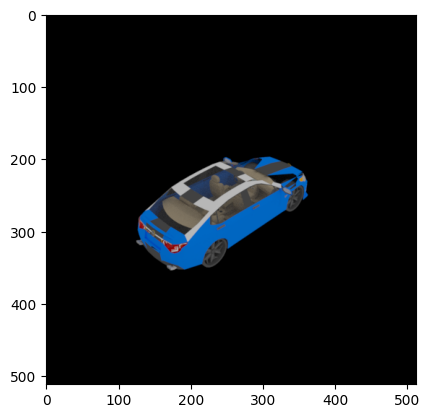

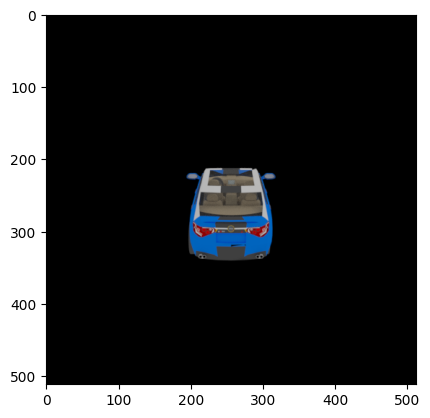

In [272]:
# code to load the obj pointcloud and the partial pointcloud and register them together 

rgb1, depth1, camera_matrix1 = get_values(rgb_path1, depth_path1, camera_transform1)
rgb2, depth2, camera_matrix2 = get_values(rgb_path2, depth_path2, camera_transform2)

# show the image loaded 
visualize_image(rgb1)
visualize_image(rgb2)

# generate the pointcloud from the unnormalized mesh obj path 
mesh = o3d.io.read_triangle_mesh(un_obj_path).sample_points_uniformly(10000).farthest_point_down_sample(5000)

# generate the pointcloud from the normalized mesh obj path 
mesh_normalized = o3d.io.read_triangle_mesh(obj_path).sample_points_uniformly(10000).farthest_point_down_sample(5000)

# register the coordinate frame and the mesh together
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)

# register the mesh and mesh_normalized together 
o3d.visualization.draw_geometries([mesh, mesh_normalized, coordinate_frame])

# load the first pointcloud
pcd1, pcd1_canonical = generate_pcd(rgb1, depth1, intrinsics, camera_matrix1)
# load the second pointcloud
pcd2, pcd2_canonical = generate_pcd(rgb2, depth2, intrinsics, camera_matrix2)

# register the canonical pointcloud and the pcd together
o3d.visualization.draw_geometries([pcd1_canonical, coordinate_frame, mesh, mesh_normalized, pcd2_canonical])

# transform the pcd by the camera transformation matrix 
# print(camera_matrix1.shape)
# camera_matrix1 = np.vstack([np.asarray(camera_matrix1, dtype=np.float64), [0, 0, 0, 1]])
# pcd1_transformed = deepcopy(pcd1).transform(np.linalg.inv(camera_matrix1))

# # register the transformed pointcloud and the mesh together
# o3d.visualization.draw_geometries([pcd1_transformed, mesh, mesh_normalized, coordinate_frame])

# translate the pointcloud by the difference in the centroidal difference of the pointcloud and the mesh
pcd1_points = np.asarray(pcd1_transformed.points)
mesh_points = np.asarray(mesh.points)
t = np.mean(pcd1_points, axis=0) - np.mean(mesh_points, axis=0)

# translate the pcd points
pcd1_points = pcd1_points - t
pcd1_transformed.points = o3d.utility.Vector3dVector(pcd1_points)
pcd1_transformed.colors = o3d.utility.Vector3dVector(pcd1.colors)

# do it for the second pointcloud as well
pcd2_points = np.asarray(pcd2_transformed.points)
mesh_points = np.asarray(mesh.points)
t = np.mean(pcd2_points, axis=0) - np.mean(mesh_points, axis=0)

# translate the pcd points 
pcd2_points = pcd2_points - t
pcd2_transformed.points = o3d.utility.Vector3dVector(pcd2_points)
pcd2_transformed.colors = o3d.utility.Vector3dVector(pcd2.colors)

# register the transformed pointcloud and the mesh together
o3d.visualization.draw_geometries([pcd1_transformed, pcd2_transformed, mesh_normalized, coordinate_frame])

# visualize just the pcd 2 transformed
o3d.visualization.draw_geometries([pcd2_transformed, mesh_normalized, coordinate_frame])

In [18]:
def get_point_cloud1(depth_maps, cam_Ks, cam_RTs, rgb_imgs=None):
    '''
    get point cloud from depth maps
    :param depth_maps: depth map list
    :param cam_Ks: corresponding camera intrinsics
    :param cam_RTs: corresponding camera rotations and translations
    :param rgb_imgs: corresponding rgb images
    :return: aligned point clouds in the canonical system with color intensities.
    '''
    point_list_canonical = []
    camera_positions = []
    color_intensities = []

    if not isinstance(rgb_imgs, np.ndarray):
        rgb_imgs = 32*np.ones([depth_maps.shape[0], depth_maps.shape[1], depth_maps.shape[2], 3], dtype=np.uint8)

    for depth_map, rgb_img, cam_K, cam_RT in zip(depth_maps, rgb_imgs, cam_Ks, cam_RTs):
        u, v = np.meshgrid(range(depth_map.shape[1]), range(depth_map.shape[0]))
        u = u.reshape([1, -1])[0]
        v = v.reshape([1, -1])[0]

        z = depth_map[v, u]

        # remove infinitive pixels
        non_inf_indices = np.argwhere(z < np.inf).T[0]

        color_indices = rgb_img[v, u][non_inf_indices]
        z = z[non_inf_indices]
        u = u[non_inf_indices]
        v = v[non_inf_indices]

        # calculate coordinates
        x = (u - cam_K[0][2]) * z / cam_K[0][0]
        y = (v - cam_K[1][2]) * z / cam_K[1][1]

        point_cam = np.vstack([x, y, z]).T

#         point_canonical = (point_cam - cam_RT[:, -1]).dot(cam_RT[:,:-1])
        
        print(f'shape of point_cam : {point_cam.shape}')
        point_cam_homo = np.vstack([point_cam.T, np.ones([point_cam.shape[0]])])
    
        point_canonical = (cam_RT @ point_cam_homo).T
    
    
        print(f'shape of point_cam : {point_cam.shape}')
        print(f'shape of point can : {point_canonical.shape}')

#         assert False
        cam_pos = - cam_RT[:, -1].dot(cam_RT[:,:-1])
        focal_point = ([0, 0, 1] - cam_RT[:, -1]).dot(cam_RT[:,:-1])
        up = np.array([0,-1,0]).dot(cam_RT[:,:-1])

        cam_pos = {'pos':cam_pos, 'fp':focal_point, 'up':up}

        point_list_canonical.append(point_canonical)
        camera_positions.append(cam_pos)
        color_intensities.append(color_indices)
        
        # create pointcloud from point cam 
        pcd_cam = o3d.geometry.PointCloud()
        pcd_cam.points = o3d.utility.Vector3dVector(point_cam)
        pcd_cam.colors = o3d.utility.Vector3dVector(color_indices/255.0)

        # create pointcloud from point can
        pcd_can = o3d.geometry.PointCloud()
        pcd_can.points = o3d.utility.Vector3dVector(point_canonical)
        pcd_can.colors = o3d.utility.Vector3dVector(color_indices/255.0)

        return pcd_cam, pcd_can
    
def get_point_cloud(depth_maps, cam_Ks, cam_RTs, rgb_imgs=None):
    '''
    get point cloud from depth maps
    :param depth_maps: depth map list
    :param cam_Ks: corresponding camera intrinsics
    :param cam_RTs: corresponding camera rotations and translations
    :param rgb_imgs: corresponding rgb images
    :return: aligned point clouds in the canonical system with color intensities.
    '''
    point_list_canonical = []
    camera_positions = []
    color_intensities = []

    if not isinstance(rgb_imgs, np.ndarray):
        rgb_imgs = 32*np.ones([depth_maps.shape[0], depth_maps.shape[1], depth_maps.shape[2], 3], dtype=np.uint8)

    for depth_map, rgb_img, cam_K, cam_RT in zip(depth_maps, rgb_imgs, cam_Ks, cam_RTs):
        u, v = np.meshgrid(range(depth_map.shape[1]), range(depth_map.shape[0]))
        u = u.reshape([1, -1])[0]
        v = v.reshape([1, -1])[0]

        z = depth_map[v, u]

        # remove infinitive pixels
        non_inf_indices = np.argwhere(z < np.inf).T[0]

        color_indices = rgb_img[v, u][non_inf_indices]
        z = z[non_inf_indices]
        u = u[non_inf_indices]
        v = v[non_inf_indices]

        # calculate coordinates
        x = (u - cam_K[0][2]) * z / cam_K[0][0]
        y = (v - cam_K[1][2]) * z / cam_K[1][1]

        point_cam = np.vstack([x, y, z]).T

        point_canonical = (point_cam - cam_RT[:, -1]).dot(cam_RT[:,:-1])

        cam_pos = - cam_RT[:, -1].dot(cam_RT[:,:-1])
        focal_point = ([0, 0, 1] - cam_RT[:, -1]).dot(cam_RT[:,:-1])
        up = np.array([0,-1,0]).dot(cam_RT[:,:-1])

        cam_pos = {'pos':cam_pos, 'fp':focal_point, 'up':up}

        point_list_canonical.append(point_canonical)
        camera_positions.append(cam_pos)
        color_intensities.append(color_indices)
        
        # create pointcloud from point cam 
        pcd_cam = o3d.geometry.PointCloud()
        pcd_cam.points = o3d.utility.Vector3dVector(point_cam)
        pcd_cam.colors = o3d.utility.Vector3dVector(color_indices/255.0)

        # create pointcloud from point can
        pcd_can = o3d.geometry.PointCloud()
        pcd_can.points = o3d.utility.Vector3dVector(point_canonical)
        pcd_can.colors = o3d.utility.Vector3dVector(color_indices/255.0)

        return pcd_cam, pcd_can
    
# load the pcd in the camera frame and the canonical frame
pcd_cam, pcd_can = get_point_cloud(np.array([depth1]), np.array([cam_K]), np.array([camera_matrix1[:-1]]), rgb_imgs=np.array([rgb1]))

# load the pcd from the mesh
mesh = o3d.io.read_triangle_mesh(obj_path).sample_points_uniformly(10000).farthest_point_down_sample(5000)
# load the coordinate frame
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)

# visualize the pcd in the camera and canonical frame
o3d.visualization.draw_geometries([pcd_cam, pcd_can, mesh, coordinate_frame])

[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D IN

In [320]:
pcd_cam, pcd_can = get_point_cloud(np.array([depth1]), np.array([cam_K]), np.array([camera_matrix1[:-1]]), rgb_imgs=np.array([rgb1]))

o3d.visualization.draw_geometries([pcd_cam])

pcd_cam_transformed = deepcopy(pcd_cam).transform(camera_matrix1)

o3d.visualization.draw_geometries([pcd_can, pcd_cam_transformed])

mesh = o3d.io.read_triangle_mesh(obj_path).sample_points_uniformly(10000).farthest_point_down_sample(5000)
mesh_points = np.array(mesh.points) - np.mean(mesh.points, axis=0)
mesh.points = o3d.utility.Vector3dVector(mesh_points)

print(np.mean(np.array(mesh.points), axis=0), np.mean(np.array(pcd_cam_transformed.points), axis=0), np.mean(np.array(pcd_can.points), axis=0))

o3d.visualization.draw_geometries([pcd_can, mesh])

[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D IN

In [6]:
mesh = o3d.io.read_triangle_mesh(obj_path).sample_points_uniformly(10000).farthest_point_down_sample(5000)
mesh1 = o3d.io.read_triangle_mesh(un_obj_path).sample_points_uniformly(10000).farthest_point_down_sample(5000)
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])
# o3d.visualization.draw_geometries([mesh, coordinate_frame])


pcd_cam, pcd_can = get_point_cloud(np.array([depth1]), np.array([cam_K]), np.array([camera_matrix1[:-1]]), rgb_imgs=np.array([rgb1]))
pcd_cam2, pcd_can2 = get_point_cloud(np.array([depth2]), np.array([cam_K]), np.array([camera_matrix2[:-1]]), rgb_imgs=np.array([rgb2]))

o3d.visualization.draw_geometries([pcd_can, pcd_can2])

o3d.visualization.draw_geometries([pcd_can, pcd_can2, mesh])
pcd_cam_transformed = deepcopy(pcd_cam).transform(np.linalg.inv(camera_matrix1))

o3d.visualization.draw_geometries([pcd_cam_transformed, pcd_can])

pcd_can_transformed_points = np.array(pcd_can.points) - np.mean(np.array(pcd_can.points), axis=0)
pcd_can_transformed = deepcopy(pcd_can)
pcd_can_transformed.points = o3d.utility.Vector3dVector(pcd_can_transformed_points)

o3d.visualization.draw_geometries([mesh, pcd_can_transformed, coordinate_frame])

[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D IN

TypeError: cannot unpack non-iterable open3d.cuda.pybind.geometry.PointCloud object

In [16]:
# generate the distance map to depth map 
from scipy.ndimage.morphology import grey_erosion
def dist_to_dep(dist_maps, cam_Ks, **kwargs):
    '''
    transform distance maps to depth maps.
    :param dist_maps: distance value maps from camera to poins
    :param cam_Ks: camera intrinsics
    :return: depth maps: z values from camera to points.
    '''

    depth_maps = np.ones_like(dist_maps) * np.inf

    view_id = 0
    for dist_map, cam_K in zip(dist_maps, cam_Ks):
        u, v = np.meshgrid(range(dist_map.shape[1]), range(dist_map.shape[0]))
        u = u.reshape([1, -1])[0]
        v = v.reshape([1, -1])[0]
        dist_cam = dist_map[v, u]

        non_inf_indices = np.argwhere(dist_cam<np.inf).T[0]
        dist_cam = dist_cam[non_inf_indices]
        u = u[non_inf_indices]
        v = v[non_inf_indices]

        # calculate coordinates
        x_temp = (u - cam_K[0][2]) / cam_K[0][0]
        y_temp = (v - cam_K[1][2]) / cam_K[1][1]
        z_temp = 1

        z = dist_cam / np.sqrt(x_temp**2 + y_temp**2 + z_temp**2)

        depth_maps[view_id, v, u] = z

        if 'erosion_size' in kwargs:
            # This is mainly result of experimenting.
            # The core idea is that the volume of the object is enlarged slightly
            # (by subtracting a constant from the depth map).
            # Dilation additionally enlarges thin structures (e.g. for chairs). (refers to Occupancy Network)
            depth_maps[view_id] = grey_erosion(depth_maps[view_id],
                                               size=(kwargs['erosion_size'], kwargs['erosion_size']))

        view_id += 1

    return depth_maps

In [19]:
depth_maps = dist_to_dep([depth1], [cam_K], erosion_size=2)
depth_map = np.array(depth_maps[0])
print(depth_map.shape)

# use the depth map to generate the pointcloud 
pcd_cam, pcd_can = get_point_cloud(np.array([depth_map]), np.array([cam_K]), np.array([camera_matrix1[:-1]]), rgb_imgs=np.array([rgb1]))
# visualize 
# o3d.visualization.draw_geometries([pcd_cam, pcd_can])

# generate the pointcloud from the depth directly
pcd_cam_d, pcd_can_d = get_point_cloud(np.array([depth1]), np.array([cam_K]), np.array([camera_matrix1[:-1]]), rgb_imgs=np.array([rgb1]))

# get the mesh pcd 
mesh = o3d.io.read_triangle_mesh(obj_path).sample_points_uniformly(10000).farthest_point_down_sample(5000)

# visualize the pcd in the camera and canonical frame
o3d.visualization.draw_geometries([pcd_can, pcd_can_d])

o3d.visualization.draw_geometries([pcd_can, pcd_can_d, mesh])

(512, 512)
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2

In [88]:
dirpath = '/home/aditya/Research/phd/code/depth_renderer/datasets/shapenet_sample_renderings/02818832/f7edc3cc11e8bc43869a5f86d182e67f/'
import os.path as osp
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2
import numpy as np
import open3d as o3d
from copy import deepcopy
import json

def get_point_cloud(depth_map, cam_K, cam_RT, rgb_img):
    '''
    get point cloud from depth maps
    :param depth_maps: depth map list
    :param cam_Ks: corresponding camera intrinsics
    :param cam_RTs: corresponding camera rotations and translations
    :param rgb_imgs: corresponding rgb images
    :return: aligned point clouds in the canonical system with color intensities.
    '''
    u, v = np.meshgrid(range(depth_map.shape[1]), range(depth_map.shape[0]))
    u = u.reshape([1, -1])[0]
    v = v.reshape([1, -1])[0]

    z = depth_map[v, u]

    # remove infinitive pixels
    non_inf_indices = np.argwhere(z < np.inf).T[0]

    color_indices = rgb_img[v, u][non_inf_indices]
    z = z[non_inf_indices]
    u = u[non_inf_indices]
    v = v[non_inf_indices]

    # calculate coordinates
    x = (u - cam_K[0][2]) * z / cam_K[0][0]
    y = (v - cam_K[1][2]) * z / cam_K[1][1]

    point_cam = np.vstack([x, y, z]).T

    point_canonical = (point_cam - cam_RT[:, -1]).dot(cam_RT[:,:-1])

    cam_pos = - cam_RT[:, -1].dot(cam_RT[:,:-1])
    focal_point = ([0, 0, 1] - cam_RT[:, -1]).dot(cam_RT[:,:-1])
    up = np.array([0,-1,0]).dot(cam_RT[:,:-1])

    cam_pos = {'pos':cam_pos, 'fp':focal_point, 'up':up}
    
    # create pointcloud from point cam 
    pcd_cam = o3d.geometry.PointCloud()
    pcd_cam.points = o3d.utility.Vector3dVector(point_cam)
    pcd_cam.colors = o3d.utility.Vector3dVector(color_indices/255.0)

    # create pointcloud from point can
    pcd_can = o3d.geometry.PointCloud()
    pcd_can.points = o3d.utility.Vector3dVector(point_canonical)
    pcd_can.colors = o3d.utility.Vector3dVector(color_indices/255.0)

    return pcd_cam, pcd_can

index = 5
image_path = osp.join(dirpath, 'color_{:03d}.png'.format(index))
depth_path = osp.join(dirpath, 'depth_{:03d}.exr'.format(index))

rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
depth = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)
print(np.unique(depth))

# plt.figure()
# plt.imshow(rgb)

# plt.figure()
# plt.imshow(depth)

# load the camera intrinsics
camk_path = '/home/aditya/Research/phd/code/depth_renderer/datasets/camera_settings/cam_K/cam_K.txt'
K = np.loadtxt(camk_path, dtype=np.float32, delimiter=' ')
print(K)

# load the camera extrinsics
extrinsics_path = '/home/aditya/Research/phd/code/depth_renderer/datasets/camera_settings/cam_RT/cam_RT_{:03d}.txt'.format(index)
camera_matrix = np.loadtxt(extrinsics_path, dtype=np.float32, delimiter=' ')
print(f'Cam matrix : {camera_matrix.shape}')

pcd_cam, pcd_can = get_point_cloud(depth, K, camera_matrix, rgb)
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)

# o3d.visualization.draw_geometries([pcd_cam, pcd_can, coordinate_frame])

# load the obj mesh file
obj_path = '/home/aditya/Research/phd/code/depth_renderer/datasets/ShapeNetCore.v2_sample/02818832/f7edc3cc11e8bc43869a5f86d182e67f/models/model_normalized.obj'
mesh = o3d.io.read_triangle_mesh(obj_path).sample_points_uniformly(10000)#.farthest_point_down_sample(5000)

pcd_transformed = deepcopy(pcd_cam).transform(np.linalg.inv(np.vstack([camera_matrix, [0, 0, 0, 1]])))
# o3d.visualization.draw_geometries([pcd_cam, pcd_can, pcd_transformed, mesh, coordinate_frame])

# read the centroid of the shapenet object and translate by that distance 
json_file = '/home/aditya/Research/phd/code/depth_renderer/datasets/ShapeNetCore.v2_sample/02818832/f7edc3cc11e8bc43869a5f86d182e67f/models/model_normalized.json'
with open(json_file) as f:
    data = json.load(f)

centroid = data['centroid']

# translate the points on the mesh by the centroid distance 
# mesh_points = np.array(mesh.points) - centroid
# mesh.points = o3d.utility.Vector3dVector(mesh_points)
# o3d.visualization.draw_geometries([pcd_cam, pcd_can, mesh, coordinate_frame])

depth_map = np.float32(dist_to_dep([depth], [cam_K]))[0]
print(f'depth map shape : {depth_map.shape}')

# use the depth maps to generate the pointclouds
pcd_cam_d, pcd_can_d = get_point_cloud(depth_map, K, camera_matrix, rgb)
# o3d.visualization.draw_geometries([pcd_can_d, mesh, coordinate_frame])

# shift the points on the mesh by the difference in the centroidal distance of pcd_can and mesh
pcd_can_points = np.array(pcd_can_d.points)
mesh_points = np.array(mesh.points)
# t = np.mean(pcd_can_points, axis=0) - np.mean(mesh_points, axis=0)
t = np.mean(mesh_points, axis=0) - np.mean(pcd_can_points, axis=0)

# translate the points on the mesh by the difference in the centroidal distance of pcd_can and mesh
mesh_points = mesh_points - t
mesh.points = o3d.utility.Vector3dVector(mesh_points)
o3d.visualization.draw_geometries([pcd_can_d, mesh, coordinate_frame]) # it looks like that these points are in the world frame

[1.8053124 1.8063769 1.8074415 1.8085059 1.8095703 1.8106349 1.8116993
 1.8127637 1.8138281 1.8148925 1.8159571 1.8170215 1.8180859 1.8191504
 1.8202149 1.8212793 1.8223437 1.8234081 1.8244727 1.8255371 1.8266016
 1.827666  1.8287306 1.829795  1.8308593 1.8319238 1.8329883 1.8340528
 1.8351172 1.8361816 1.8372462 1.8383106 1.839375  1.8404394 1.8415039
 1.8425684 1.8436328 1.8446972 1.8457618 1.8468262 1.8478906 1.848955
 1.8500195 1.851084  1.8521484 1.853213  1.8542774 1.8553419 1.8564063
 1.8574706 1.8585352 1.8595996 1.8606641 1.8617285 1.862793  1.8638575
 1.8649219 1.8659863 1.8670508 1.8681152 1.8691797 1.8702441 1.8713086
 1.8723731 1.8734375 1.874502  1.8755664 1.8766308 1.8776953 1.8787597
 1.8798243 1.8808887 1.8819532 1.8830177 1.884082  1.8851465 1.8862109
 1.8872755 1.8883399 1.8894043 1.8904688 1.8915333 1.8925977 1.8936621
 1.8947265 1.895791  1.8968555 1.8979199 1.8989844 1.9000489 1.9011133
 1.9021777 1.9032421 1.9043067 1.9053711 1.9064356 1.9075    1.9085646
 1.9096

In [100]:
# load the saved pcd and mesh
saved_pcds = '/home/aditya/Research/phd/code/depth_renderer/datasets/point_clouds'
mesh_path = '/home/aditya/Research/phd/code/depth_renderer/datasets/ShapeNetCore.v2_sample/02818832/e91c2df09de0d4b1ed4d676215f46734/models/model_normalized.obj'

print(osp.exists(mesh_path))

pcd_files = sorted(glob(saved_pcds + '/*.npy'))
pcd_points = np.load(pcd_files[0])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pcd_points)
pcd.paint_uniform_color([1, 0, 0])

mesh = o3d.io.read_triangle_mesh(mesh_path).sample_points_uniformly(20000)#.farthest_point_down_sample(5000)
mesh.paint_uniform_color([0, 0, 1])

# translate the mesh by some distance to see separation in the two pointclouds 
mesh_points = np.array(mesh.points) - np.array([0.5, 0.5, 0.5])
mesh.points = o3d.utility.Vector3dVector(mesh_points)

coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)

o3d.visualization.draw_geometries([mesh, coordinate_frame, pcd])


True
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open

In [4]:
import imageio
import sys
sys.path.append('../')
from data_config import *
from tools.read_and_write import *
import random

def read_exr(exr_file_list):
    print(f'The exr file list is : {exr_file_list}')
    '''
    read exr files and output a matrix.
    :param exr_file_list:
    :return:
    '''
    if isinstance(exr_file_list, str):
        exr_file_list = [exr_file_list]

    im_list = []

    for exr_file in exr_file_list:
        if not exr_file.endswith('exr'):
            raise TypeError('file is not with the format of .exr.')

        im_list.append(imageio.imread(exr_file, format='exr')[:,:,0])

    return np.array(im_list)

# get the pointcloud given the rgb image and the depth map 
def get_point_cloud(depth_maps, cam_Ks, cam_RTs, rgb_imgs=None):
    '''
    get point cloud from depth maps
    :param depth_maps: depth map list
    :param cam_Ks: corresponding camera intrinsics
    :param cam_RTs: corresponding camera rotations and translations
    :param rgb_imgs: corresponding rgb images
    :return: aligned point clouds in the canonical system with color intensities.
    '''
    point_list_canonical = []
    camera_positions = []
    color_intensities = []

    if not isinstance(rgb_imgs, np.ndarray):
        rgb_imgs = 32*np.ones([depth_maps.shape[0], depth_maps.shape[1], depth_maps.shape[2], 3], dtype=np.uint8)

    for depth_map, rgb_img, cam_K, cam_RT in zip(depth_maps, rgb_imgs, cam_Ks, cam_RTs):
        u, v = np.meshgrid(range(depth_map.shape[1]), range(depth_map.shape[0]))
        u = u.reshape([1, -1])[0]
        v = v.reshape([1, -1])[0]

        z = depth_map[v, u]

        # remove infinitive pixels
        non_inf_indices = np.argwhere(z < np.inf).T[0]

        color_indices = rgb_img[v, u][non_inf_indices]
        z = z[non_inf_indices]
        u = u[non_inf_indices]
        v = v[non_inf_indices]

        # calculate coordinates
        x = (u - cam_K[0][2]) * z / cam_K[0][0]
        y = (v - cam_K[1][2]) * z / cam_K[1][1]

        point_cam = np.vstack([x, y, z]).T

        point_canonical = (point_cam - cam_RT[:, -1]).dot(cam_RT[:,:-1])
        cam_pos = - cam_RT[:, -1].dot(cam_RT[:,:-1])
        focal_point = ([0, 0, 1] - cam_RT[:, -1]).dot(cam_RT[:,:-1])
        up = np.array([0,-1,0]).dot(cam_RT[:,:-1])

        cam_pos = {'pos':cam_pos, 'fp':focal_point, 'up':up}

        # point_clouds.append(np.expand_dims(point_canonical, axis=0))

        point_list_canonical.append(point_canonical)
        camera_positions.append(cam_pos)
        color_intensities.append(color_indices)

    return point_list_canonical, camera_positions, color_intensities

depth_sample_dir = '02818832/e91c2df09de0d4b1ed4d676215f46734'
n_views = 20
assert n_views <= total_view_nums # there are total 20 views surrounding an object.
view_ids = range(1, n_views+1)

shapenet_rendering_path = '../datasets/supercloud/test_shapenet_renders'
metadata_dir = os.path.join(shapenet_rendering_path, depth_sample_dir)
print(f'metadata_dir : {metadata_dir}')
dist_map_dir = [os.path.join(metadata_dir, 'depth_{0:03d}.exr'.format(view_id)) for view_id in view_ids]
print(f'dist map dir : {dist_map_dir}')
camera_path = '../datasets/camera_settings'
cam_RT_dir = [os.path.join(camera_path, 'cam_RT','cam_RT_{0:03d}.txt'.format(view_id)) for view_id in view_ids]

dist_maps = read_exr(dist_map_dir)
cam_K = np.loadtxt(os.path.join(camera_path, 'cam_K/cam_K.txt'))
cam_RTs = read_txt(cam_RT_dir)

depth_maps = np.float32(dist_to_dep(dist_maps, [cam_K]*len(view_ids)))
rgb_images = [os.path.join(metadata_dir, 'color_{0:03d}.png'.format(view_id)) for view_id in view_ids]
point_list_canonical, camera_positions, color_intensities = get_point_cloud(depth_maps, [cam_K]*len(view_ids), cam_RTs, rgb_imgs=read_image(rgb_images))

# visualize the pointcloud 
pcd_index = random.randint(0, len(point_list_canonical)-1)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.vstack(point_list_canonical))
pcd.colors = o3d.utility.Vector3dVector(np.vstack(color_intensities)/255.0)

# pcd_combined = o3d.geometry.PointCloud()
# pcd_combined.points = o3d.utility.Vector3dVector(np.vstack(point_list_canonical))

# read the mesh and register that against the pointcloud 
obj_path = '/home/aditya/Research/phd/code/depth_renderer/datasets/ShapeNetCore.v2_sample/02818832/e91c2df09de0d4b1ed4d676215f46734/models/model_normalized.obj'
mesh = o3d.io.read_triangle_mesh(obj_path).sample_points_uniformly(20000)#.farthest_point_down_sample(5000)

o3d.visualization.draw_geometries([pcd, mesh])

metadata_dir : ../datasets/supercloud/test_shapenet_renders/02818832/e91c2df09de0d4b1ed4d676215f46734
dist map dir : ['../datasets/supercloud/test_shapenet_renders/02818832/e91c2df09de0d4b1ed4d676215f46734/depth_001.exr', '../datasets/supercloud/test_shapenet_renders/02818832/e91c2df09de0d4b1ed4d676215f46734/depth_002.exr', '../datasets/supercloud/test_shapenet_renders/02818832/e91c2df09de0d4b1ed4d676215f46734/depth_003.exr', '../datasets/supercloud/test_shapenet_renders/02818832/e91c2df09de0d4b1ed4d676215f46734/depth_004.exr', '../datasets/supercloud/test_shapenet_renders/02818832/e91c2df09de0d4b1ed4d676215f46734/depth_005.exr', '../datasets/supercloud/test_shapenet_renders/02818832/e91c2df09de0d4b1ed4d676215f46734/depth_006.exr', '../datasets/supercloud/test_shapenet_renders/02818832/e91c2df09de0d4b1ed4d676215f46734/depth_007.exr', '../datasets/supercloud/test_shapenet_renders/02818832/e91c2df09de0d4b1ed4d676215f46734/depth_008.exr', '../datasets/supercloud/test_shapenet_renders/0281

/tmp/ipykernel_3298051/1715405392.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im_list.append(imageio.imread(exr_file, format='exr')[:,:,0])


FileNotFoundError: No such file: '/home/aditya/Research/phd/code/supercloud/depth_renderer/datasets/supercloud/test_shapenet_renders/02818832/e91c2df09de0d4b1ed4d676215f46734/depth_001.exr'

In [16]:
import imageio
import sys
sys.path.append('../')
from data_config import *
from tools.read_and_write import *
import random

def read_exr(exr_file_list):
    print(f'The exr file list is : {exr_file_list}')
    '''
    read exr files and output a matrix.
    :param exr_file_list:
    :return:
    '''
    if isinstance(exr_file_list, str):
        exr_file_list = [exr_file_list]

    im_list = []

    for exr_file in exr_file_list:
        if not exr_file.endswith('exr'):
            raise TypeError('file is not with the format of .exr.')

        im_list.append(imageio.imread(exr_file, format='exr')[:,:,0])

    return np.array(im_list)

# get the pointcloud given the rgb image and the depth map 
def get_point_cloud(depth_maps, cam_Ks, cam_RTs, rgb_imgs=None):
    '''
    get point cloud from depth maps
    :param depth_maps: depth map list
    :param cam_Ks: corresponding camera intrinsics
    :param cam_RTs: corresponding camera rotations and translations
    :param rgb_imgs: corresponding rgb images
    :return: aligned point clouds in the canonical system with color intensities.
    '''
    point_list_canonical = []
    camera_positions = []
    color_intensities = []

    if not isinstance(rgb_imgs, np.ndarray):
        rgb_imgs = 32*np.ones([depth_maps.shape[0], depth_maps.shape[1], depth_maps.shape[2], 3], dtype=np.uint8)

    for depth_map, rgb_img, cam_K, cam_RT in zip(depth_maps, rgb_imgs, cam_Ks, cam_RTs):
        u, v = np.meshgrid(range(depth_map.shape[1]), range(depth_map.shape[0]))
        u = u.reshape([1, -1])[0]
        v = v.reshape([1, -1])[0]

        z = depth_map[v, u]

        # remove infinitive pixels
        non_inf_indices = np.argwhere(z < np.inf).T[0]

        color_indices = rgb_img[v, u][non_inf_indices]
        z = z[non_inf_indices]
        u = u[non_inf_indices]
        v = v[non_inf_indices]

        # calculate coordinates
        x = (u - cam_K[0][2]) * z / cam_K[0][0]
        y = (v - cam_K[1][2]) * z / cam_K[1][1]

        point_cam = np.vstack([x, y, z]).T

        point_canonical = (point_cam - cam_RT[:, -1]).dot(cam_RT[:,:-1])
        cam_pos = - cam_RT[:, -1].dot(cam_RT[:,:-1])
        focal_point = ([0, 0, 1] - cam_RT[:, -1]).dot(cam_RT[:,:-1])
        up = np.array([0,-1,0]).dot(cam_RT[:,:-1])

        cam_pos = {'pos':cam_pos, 'fp':focal_point, 'up':up}

        # point_clouds.append(np.expand_dims(point_canonical, axis=0))

        point_list_canonical.append(point_canonical)
        camera_positions.append(cam_pos)
        color_intensities.append(color_indices)

    return point_list_canonical, camera_positions, color_intensities

# # depth_sample_dir = '02818832/e91c2df09de0d4b1ed4d676215f46734'
# # synset_id = shapenet_categlory_pair['table']
# synset_id = shapenet_categlory_pair['car']
# # shapenet_rendering_path = '../datasets/test_shapenet_renders'
# shapenet_rendering_path = '../datasets/supercloud/test_shapenet_renders'
# cate_instances = [filename.split('/')[-1] for filename in glob(osp.join(shapenet_rendering_path, synset_id, '*'))]
# print(f'cate instances : {cate_instances}')
# cate_instance = cate_instances[random.randint(0, len(cate_instances)-1)]
# depth_sample_dir = '{}/{}'.format(synset_id, cate_instance)
# n_views = 20
# assert n_views <= total_view_nums # there are total 20 views surrounding an object.
# view_ids = range(1, n_views+1)

# # shapenet_rendering_path = '../datasets/shapenet_sample_renderings'
# # shapenet_rendering_path = '../datasets/ShapeNetRenderings'

# metadata_dir = os.path.join(shapenet_rendering_path, depth_sample_dir)
# print(f'metadata_dir : {metadata_dir}')
# dist_map_dir = [os.path.join(metadata_dir, 'depth_{0:03d}.exr'.format(view_id)) for view_id in view_ids]
# print(f'dist map dir : {dist_map_dir}')
# camera_path = '../datasets/camera_settings'
# cam_RT_dir = [os.path.join(camera_path, 'cam_RT','cam_RT_{0:03d}.txt'.format(view_id)) for view_id in view_ids]

# dist_map_exist = [osp.exists(dist_map) for dist_map in dist_map_dir]
# print(f'dist map exist : {dist_map_exist}')
# dist_maps = read_exr(dist_map_dir)
# cam_K = np.loadtxt(os.path.join(camera_path, 'cam_K/cam_K.txt'))
# cam_RTs = read_txt(cam_RT_dir)

# depth_maps = np.float32(dist_to_dep(dist_maps, [cam_K]*len(view_ids)))
# rgb_images = [os.path.join(metadata_dir, 'color_{0:03d}.png'.format(view_id)) for view_id in view_ids]
# point_list_canonical, camera_positions, color_intensities = get_point_cloud(depth_maps, [cam_K]*len(view_ids), cam_RTs, rgb_imgs=read_image(rgb_images))

# # visualize the pointcloud 
# pcd_index = random.randint(0, len(point_list_canonical)-1)
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(np.vstack(point_list_canonical))
# pcd.colors = o3d.utility.Vector3dVector(np.vstack(color_intensities)/255.0)

# # pcd_combined = o3d.geometry.PointCloud()
# # pcd_combined.points = o3d.utility.Vector3dVector(np.vstack(point_list_canonical))

# # read the mesh and register that against the pointcloud 
# # obj_path = '/home/aditya/Research/phd/code/depth_renderer/datasets/ShapeNetCore.v2_sample/{}/models/model_normalized.obj'.format(depth_sample_dir)
# obj_path = '/home/aditya/Research/phd/code/datasets/shapenetcore/{}/models/model_normalized.obj'.format(depth_sample_dir)
# # obj_path = '/home/aditya/Research/phd/code/depth_renderer/datasets/test_shapenet_normalized/{}/models/model_normalized.obj'.format(depth_sample_dir)
# mesh = o3d.io.read_triangle_mesh(obj_path).sample_points_uniformly(20000)#.farthest_point_down_sample(5000)

# # draw the coordinate frame 
# coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.3)

# o3d.visualization.draw_geometries([pcd, mesh, coordinate_frame])
# o3d.visualization.draw_geometries([mesh, coordinate_frame])

In [152]:
# load the normalized and unnormalized mesh together 
from glob import glob 
import random
import torch

cat_name = 'car'
synset_id = shapenet_categlory_pair[cat_name]

unnormalized_path = '/home/aditya/Research/phd/code/datasets/shapenetcore/'
normalized_path = '../datasets/ShapeNetCore.v2_normalized/'

cat_instances = [filename.split('/')[-1] for filename in glob(osp.join(unnormalized_path, synset_id, '*'))]
print(f'cat instances : {cat_instances}')
cat_instance = cat_instances[random.randint(0, len(cat_instances)-1)]

dirpath = '{}/{}'.format(synset_id, cat_instance)

un_obj_path = osp.join(unnormalized_path, dirpath, 'models/model_normalized.obj')
obj_path = osp.join(normalized_path, dirpath, 'models/model_normalized.obj')

print(osp.exists(un_obj_path), osp.exists(obj_path))

# read the meshes from both the object paths and register them together 
mesh_obj = o3d.io.read_triangle_mesh(obj_path).sample_points_uniformly(10000)#.farthest_point_down_sample(5000)
mesh_un_obj = o3d.io.read_triangle_mesh(un_obj_path).sample_points_uniformly(10000)#.farthest_point_down_sample(5000)

# o3d.visualization.draw_geometries([mesh_obj, mesh_un_obj])

print(np.min(np.array(mesh_obj.points)), np.max(np.array(mesh_obj.points)))
print(np.min(np.array(mesh_un_obj.points)), np.max(np.array(mesh_un_obj.points)))

# obj_min, obj_max = np.min(mesh_obj.points, dim=0)[0], torch.max(mesh_obj.points, dim=0)[0]
# un_obj_min, un_obj_max = torch.min(mesh_un_obj.points, dim=0)[0], torch.max(mesh_un_obj.points, dim=0)[0]

cat instances : ['60458c0d233ccf9daa69dfdc5532bb13', '5d8476a9aecbbe1e9ec9fbf723f60ac0', '1ee4f19fa617ec5949493d905c02fa86', 'a077e24f8983d3d3476c231adfa21265', '39cb477c0a03aa1c3ab1417a5ca1ff4', 'abc42e7c5ffaa41d1466737d5c4b4246', 'a83c45069b2925efa7e7e5ea49ad8e45', '17457b1f42019702618e9d35559b7aa', 'fa8ecf7278bb320bb7ecd40416f4e39', '7af4a575dc3883afab355379ede04b04', 'b1ad30609c2fa8a2d63b3823877bfa70', '93f298a78be6883916abce8cb03e7794', '1d82316d98f620513b86a9df4269733', '72d4244540e81c671d9826a79afd9186', '3ef7cfbc172840b2393bf61b30c528bb', '84e4dd1c6306a582a97e62e669e9544d', 'a421aeec78440e40d3a3ff116860ca63', 'a5464210795a915f9aa6f213afdff14d', '9702eb7f07f013532764cfba57a5de73', '4baaabaced0c9e0ac0e3666c7d0ec7d0', 'c00e0066715c2226921cb81cb1632a5e', 'ee63549013035c385e28caa3b26a73fd', '6d083701a45fd0721ccbd9e5bb82dd04', '6749e5a1458ead5abda733a39f84326d', '115170b8b44f9e2e5b2bb28aa7453162', '2b0207d7f6a6f23bf0ff8cc77ea4c273', '26cc3a9cc0c28174ae30cad08127b470', '77065a7bc997ba

In [31]:
import os.path as osp
import open3d as o3d
import os
from glob import glob
import random
import numpy as np
import imageio.v2 as imageio

def read_exr(exr_file):
    '''
    exr_file : str
    return : numpy array of shape (H, W)
    '''
    if not exr_file.endswith('exr'):
        raise TypeError('file is not with the format of .exr.')

    return np.array(imageio.imread(exr_file, format='exr')[:,:,0])

# load the mesh pointcloud 
def load_mesh_pointcloud(obj_file, num_points_downsample=2048):
    mesh = o3d.io.read_triangle_mesh(obj_file)
    pcd = mesh.sample_points_uniformly(10000).farthest_point_down_sample(num_points_downsample)

    return pcd

# read the image file 
def read_image(img_file):
    return np.array(imageio.imread(img_file, format='png'))

def load_camRT(camRT_file):
    return np.loadtxt(camRT_file)

def get_point_cloud(depth_map, cam_K, cam_RT, rgb_img):
    u, v = np.meshgrid(range(depth_map.shape[1]), range(depth_map.shape[0]))
    u = u.reshape([1, -1])[0]
    v = v.reshape([1, -1])[0]

    z = depth_map[v, u]

    # remove infinitive pixels
    non_inf_indices = np.argwhere(z < np.inf).T[0]

    color_indices = rgb_img[v, u][non_inf_indices]
    z = z[non_inf_indices]
    u = u[non_inf_indices]
    v = v[non_inf_indices]

    # calculate coordinates
    x = (u - cam_K[0][2]) * z / cam_K[0][0]
    y = (v - cam_K[1][2]) * z / cam_K[1][1]

    point_cam = np.vstack([x, y, z]).T

    point_canonical = (point_cam - cam_RT[:, -1]).dot(cam_RT[:,:-1])
    cam_pos = - cam_RT[:, -1].dot(cam_RT[:,:-1])
    focal_point = ([0, 0, 1] - cam_RT[:, -1]).dot(cam_RT[:,:-1])
    up = np.array([0,-1,0]).dot(cam_RT[:,:-1])

    cam_pos = {'pos':cam_pos, 'fp':focal_point, 'up':up}

    return point_cam, point_canonical, color_indices
    
import sys
sys.path.append('..')
from data_config import shapenet_categlory_pair, synset_category_pair

dataset_dirpath = '../../../datasets/'
shapenet_objects = osp.join(dataset_dirpath, 'ShapeNetCore_Zip')
shapenet_renders = osp.join(dataset_dirpath, 'shapenet_renders')

rendered_categories = os.listdir(shapenet_renders)
print(rendered_categories)

category_name = 'car'
category_id = shapenet_categlory_pair[category_name]

obj_category_path = osp.join(shapenet_objects, category_id)
rendered_category_path = osp.join(shapenet_renders, category_id)

instances = glob(rendered_category_path + '/*')

random_idx = random.randint(0, len(instances)-1)
instance = instances[random_idx]
print(instance)

obj_path = osp.join(obj_category_path, osp.basename(instance), 'models/model_normalized.obj')
print(osp.exists(obj_path))

# load the camera settings 
camera_settings = osp.join(dataset_dirpath, 'camera_settings')
camk_path = osp.join(camera_settings, 'cam_K/cam_K.txt')
camRT_path = osp.join(camera_settings, 'cam_RT')

cam_K = np.loadtxt(camk_path, dtype=np.float32, delimiter=' ')

# choose a random viewpoint and load the image, depth, and camera matrix 
image_paths = sorted(glob(instance + '/*.png'))
depth_paths = sorted(glob(instance + '/*.exr'))
cam_RT_paths = sorted(glob(camRT_path + '/*'))

viewpoint = random.randint(0, len(cam_RT_paths)-1)

image_path = image_paths[viewpoint]
depth_path = depth_paths[viewpoint]
cam_RT_path = cam_RT_paths[viewpoint]

cam_RT = load_camRT(cam_RT_path)

rgb = read_image(image_path)
depth = read_exr(depth_path)

point_cam, point_can, colors = get_point_cloud(depth, cam_K, cam_RT, rgb)

pcd_cam = o3d.geometry.PointCloud()
pcd_cam.points = o3d.utility.Vector3dVector(point_cam)

pcd_can = o3d.geometry.PointCloud()
pcd_can.points = o3d.utility.Vector3dVector(point_can)

o3d.visualization.draw_geometries([pcd_cam, pcd_can])

['02876657', '03759954', '03001627', '02954340', '04401088', '02801938', '03991062', '02942699', '02992529', '03513137', '02773838', '04074963', '04256520', '03790512', '03261776', '04530566', '03046257', '02880940', '03636649', '02691156', '02946921', '02958343', '03797390', '04468005', '03642806', '03593526', '02924116', '02747177', '03624134']
../../../datasets/shapenet_renders/02958343/ee63549013035c385e28caa3b26a73fd
True
[Open3D WARNING] GLFW Error: GLX: Failed to create context: GLXBadFBConfig
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast
